# Lyman-n forest of a homogeneous universe

assume a constant density. 

$$ N_{HI} = 10^{14} \big(\frac{dv}{10km s^{-1}}\big) cm^{-2} $$


Then:

$$ \tau_{Ly\alpha} = 1 \rightarrow \tau_{n} = \frac{gf_{1n}}{gf_{Ly\alpha}} $$ 

In [2]:
%matplotlib inline
import numpy as np
from __future__ import division
import matplotlib.pyplot as plt
from scipy.integrate import quad
import astropy.constants as const
import astropy.units as u

Initial Parameters

In [3]:
# number of cells
N = 5000

# make a velocity array with the correspoding length and delta v
dv = 100 # km/s
v = np.arange(N)*dv

# constant column density
N_HI_cell = 1e14*(dv/100) # g cm^-2

c = const.c.to(u.km / u.s).value # km/s
R_h = const.Ryd.to(1 / u.Angstrom).value # Rydberg constant in 1 /angstroms

$$ \lambda_{obs} \approx \lambda_{emit}\big(1 + \frac{dv}{c}\big) $$




In [4]:
wav_min = 600.0
wav_em = np.zeros(N)
#z_em = (wav_em.max() - wav_em)/wav_min

dz = np.zeros(N+1)
wav_em[0]=wav_min
#dz[0]=0
for i in range(1, N):
    wav_em[i] = wav_em[i-1]*(1 + dv/c)
    #dz[i] = wav_em[i]/wav_min-1

compute the proper distance accross each cell

## Add Lyman continuum opacity

$$ \frac{\tau_{\alpha}}{\sigma_{\alpha}} = N_{HI} $$

compute the column density at each cell

In [5]:
lymanlimit = 911.267050642
sigma0 = 6.30e-18


def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx


# print imax, wav_em[imax], np.sum(wav_em[imax-10:imax]**3)
def tau_bf(wave_em, column_density):
    lymanlimit = 911.267050642
    sigma0 = 6.30e-18
    t_bf = np.zeros(N)
    imax = find_nearest(wave_em, lymanlimit)
    for i in xrange(N):
        if i < imax:
            t_bf[i] = sigma0*(column_density/lymanlimit**3)*np.sum(wave_em[i:imax]**3)
            
    return t_bf

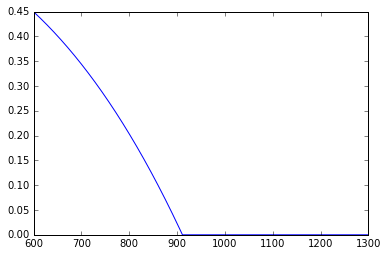

In [6]:
t_bf = tau_bf(wav_em, N_HI_cell)
plt.plot(wav_em, t_bf)
plt.xlim(600, 1300)
plt.show()

## Add the Lyman-n Forest

In [7]:
def tau_Lya(z, rho=1):
    """ From McQuinn IGM revieTw"""
    chi_H = 1e-5 # at z~3
    # rho = 1 # no density fluctuations
    return 1.3*rho*(chi_H/1e-5)*((1 + z)/4)**(3/2)

In [8]:
#from numba.decorators import jit
#@jit
def gf_1n(nn):
    """ A function to calculate the oscillator strengths of of the Lyman series (n'=1).
        
        Reference: RL equation 10.46 (p.281)
    """
    if nn == 1:
        gf = 1.0
    elif nn == 0:
        gf = 1.0
    else:
        gf = (2**9 * nn**5 * (nn-1)**(2*nn-4)) / (3*(nn+1)**(2*nn+4))
    return gf

gf_1n = np.vectorize(gf_1n)


def lyman_lambda(nmax):
    return (R_h*(1 - (1/nmax**2)))**-1

lyman_wav = np.vectorize(lyman_lambda)

In [9]:
lymanlimit = lyman_wav(100000)

$ \tau_{n} = \frac{gf_{1n}}{gf_{Ly\alpha}} \tau_{Ly\alpha}$

In [10]:
tau_n = (gf_1n(np.arange(2,1000))/gf_1n(2))*tau_Lya(0)

In [11]:
f_n = (gf_1n(np.arange(2,1000))/gf_1n(2))

In [12]:
lambda_n = lyman_lambda(np.arange(2,len(tau_n)+2))
print lambda_n.size

998


In [19]:
tau_Ly = np.zeros(N)
for f,l in zip(f_n[::-1], lambda_n[::-1]):
    # where does wav_em == lyman-n line
    i = find_nearest(wav_em,l)
    
    # stack this opacity on to the opacity array
    # tau_Ly[:i] += tau_Ly[i]*f
    tau_Ly[:i] += f
    # tau_Ly[:i] += 1.

(0, 50)

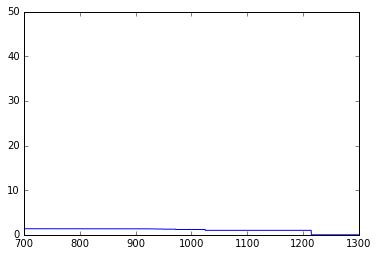

In [20]:
plt.plot(wav_em, tau_Ly)
plt.xlim(700, 1300)
plt.ylim(0,50)

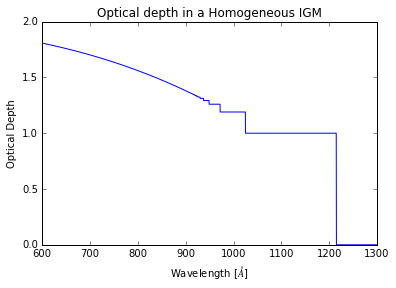

In [21]:
# tau_Ly[wav_em < 911.267050642] = 0
plt.plot(wav_em, t_bf + tau_Ly)
plt.xlim(600, 1300)
plt.title("Optical depth in a Homogeneous IGM")
plt.xlabel(r"Wavelength [$\AA$]")
plt.ylabel(r"Optical Depth")
plt.show()

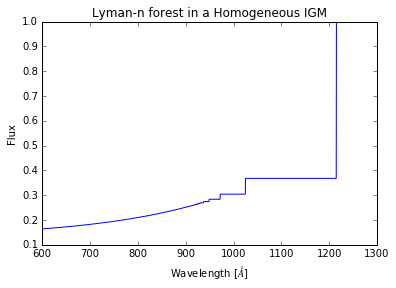

In [22]:
tau_tot = t_bf + tau_Ly
# plt.figure(figsize=(8,6))
plt.plot(wav_em, np.exp(-tau_tot))
plt.xlim(600, 1300)
plt.title("Lyman-n forest in a Homogeneous IGM")
plt.xlabel(r"Wavelength [$\AA$]")
plt.ylabel(r"Flux")
plt.show()